<center><h1><FONT FACE="Vollkorn"><Font Color=navy> Blanket PO Analysis</h1> 
<center><h2> <OL Type = ' '> Identification of Blanket POs at SciQuest Campuses</h2>
<p>
<img src="http://calwatchdog.com/wp-content/uploads/2013/09/University_of_California_seal.png" style="float: left; width: 30%; margin-left: 10%; margin-bottom: 0.5em;">

<img src="http://identity.ucsf.edu/sites/identity.ucsf.edu/files/styles/pharmacy_full/public/po_brand_a_masterlogo_1.png?itok=DbTSjNYS" style="float: right; width: 50%; margin-right: 10%; margin-bottom: 0.5em;">
<p style="clear: both;">


<br>
<br>
<Center><h3>Andrew G. Clark
<Center><a href="mailto:andrew.clark@ucsf.edu">andrew.clark@ucsf.edu</a> | <a href="mailto:aclark@berkeley.edu">aclark@berkeley.edu</a>
<Center>University of California, Berkeley and San Francisco</h3>
<p>
<Center><h5>Built on the 2014 work of Alexis Perez, Analyst 1

<Font FACE= Times><Font Size= 4> <b>Introduction<p> </b>
<p>
    As of January 2015, UCSF and Berkeley permit campus departments to establish Blanket Purchase Orders and use them in the procurement of goods and services.  Under such an arrangement, the procurement department pre-authorizes a sum of money for use with a specific supplier.  The department representative may then use that money for any goods/services from that supplier.  There are no reports or indicators to tell Procurement any information about blanket POs.
           <p>
<t>
<b> The Analysis:</b>
<p>
    Using the default invoice extract from SciQuest, we can derive attributes about the PO and invoices referencing them which allow us to predict whether a PO is a blanket PO or not.  This process is generalized to apply broadly, so we only consider operational flags if they are standard across all UC instances.  We first use a simple rules based system to find the Blankets.  We then experiment with Logistic Regression to see whether we get an improvement in time/accuracy.
<p>
<t>
<b> Software Requirements:</b>
<p>
        This analysis uses the UCSF/Berkeley procurement standard analytic suite which includes Anaconda Python 2.7 along with several opensource python modules.
        
<p>
<t>
<b> Data Requirements:</b>
<p>
    This analysis is built using SciQuest's invoice extract file, without modification.  The fields differ between campus, so we have used column names try statements where we found differences.
<p>
<t>
<b> Future Improvements:</b>
<p>
    <ul>
        <li> Create converters to pull the data into the analysis into the correct format (time sync?).
        <li> The rules based system uses <i>% of PO used</i> as a feature.  This potentially excludes blanket POs which are almost used up. A better feature is warrented.
        <li> Optimize code
        <li> Remove the filter to PO's which begin with "b".  That is a Berkeley/UCSF convention.
        <li> This analysis would be better if we had Invoice Line Count.  That data isnt in the SQ extract.

In [1]:
%matplotlib inline
#Import required modules required to complete the analysis
import pandas as pd
import datetime
import numpy as np
from pandas import pivot_table
from pandas import merge
from pandas import DataFrame
from __future__ import division

#Load some variables for use later
Campus = 'UCB'

#Location of the Invoice Extract File to be used in the analysis
data = pd.read_csv('BuyerInvoice_Data_Vouchers.csv');

#Create a new column named campus and fill it with the campus name for later
data['Campus'] = Campus

C:\Anaconda\lib\site-packages\pandas\io\parsers.py:1159: DtypeWarning: Columns (77,139) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


## Format the File

<Font FACE= Times><Font Size= 4>Even though UCSF and Berkeley both utelize "BearBuy", the Invoice Extract file from the two systems differ.  This block of code normalizes the files to ensure the remainder of the analysis can be standard.

In [8]:
if Campus == 'UCSF':
    data.rename(columns={'PO No':'PO #', 
                         'Invoice Line Extended Price':'Extended Price1',
                         'PO Line Extended Price':'Extended Price2',
                         'PO Line No':'PO Line #',
                         'Voucher No':'Voucher #',
                         'Invoice System Created Date':'Invoice System Creation Date',
                         'Home Department Name':'Department Name'
                         }, inplace=True)

if Campus == 'UCB':
    data.rename(columns={'Voucher Type':'Invoice Type',
                         'PO No':'PO #', 
                         'Invoice Line Extended Price':'Extended Price1',
                         'PO Line Extended Price':'Extended Price2',
                         'PO Line No':'PO Line #',
                         'Voucher No':'Voucher #',
                         'Invoice System Created Date':'Invoice System Creation Date',
                         'Home Department Name':'Department Name',
                         'Voucher Total':'Invoice Total'
                         }, inplace=True)

##Change these values to be floats to filter and do calculations by them
try:
    if data['Extended Price2'].dtype is np.dtype('O'):
      data['Extended Price2'] = data['Extended Price2'].str.replace('$','').str.replace(',','').astype('float32')
except:
    pass

try:
    if data['Invoice Total'].dtype is np.dtype('O'):
      data['Invoice Total'] = data['Invoice Total'].str.replace('$','').str.replace(',','').astype('float32')
except:
    pass

try:
    if data['Extended Price1'].dtype is np.dtype('O'):
      data['Extended Price1'] = data['Extended Price1'].str.replace('$','').str.replace(',','').astype('float32')
except:
    pass

##Create The PO Feature Matrix

<Font FACE= Times><Font Size= 4>We can make substantial progress toward finding blanket POs by simply removing those POs/invoices that can't be blankets.  To do that, we filter the PO data in several intuitive ways, exluding pending, cancelled, and rejected invoices.  We also exclude those transaction types that cannot possibly generate a blanket PO, like those originating from the hosted catalogs.
<p>
Following the filter, we then begin calculating our PO features.  For this analysis we will calculate two features, the percent of PO dollars used and the number of invoices received against the PO.  


In [9]:
#To filter the data, We want to:
#               Include POs beginning with "B"
#               Exclude rejected Vouchers/Invoices
#               Include Positive value prices and not credit memos (dont want product returns)
#               Exclude SQ Hosted Product or Contract Non-CatalogItems (Impossible for blankets)
#               Exclude cancelled lines
#               Exclude Pending workflow status
#               Exclude POs that have been used up or not used at all


data_filtered = data[(data['PO #'].str.startswith('B')) & 
                     (data['Voucher Status'] != 'Rejected') &
                     (data['Extended Price1'] > 0) &
                     (data['Item Type'] != 'SQ Hosted Product') &
                     (data['Item Type'] != 'Contract NonCatalogItem') &
                     (data['Invoice Type'] != 'Credit memo') &
                     (data['Line Status'] == 'Approved') &
                     (data['Workflow Status'] == 'Complete')
                    ]

#Find all PO's which reference the word "Blanket" as those are probably Blanket POs.
data_filtered['Blanket'] = data_filtered['Product Name'].str.contains('blanket', case=False)

#Create the PO feature matrix by creating a pivot table of sums and counts. Then filter out the
#columns that dont make sense.  The resulting data will look like:
#PO#--Count of Lines--Count of Invoices--Total $--Dollars Used--Invoice Owner--Campus--Supplier
PO_pivot = pivot_table(data_filtered, rows=['PO #','Supplier Name','Campus','Blanket'], 
                       values = ['Invoice Total','Extended Price1','Extended Price2','PO Line #','Voucher #'], 
                       aggfunc = [np.sum, lambda x: len(x.unique())])

#create a list of the columns so I can exclude nonsense columns
cols = PO_pivot.columns.tolist()

#columns I want to exclude (numbering starts with zero)
indices = 2,3,4,5,6

#Run through the column list and remove the indices columns
cols = [i for j, i in enumerate(cols) if j not in indices]

#Create the PO_feature matrix with nicely named columns
PO_features = PO_pivot[cols].reset_index()

#rename the columns for ease of reference
PO_features.columns = ['PO #', 'Supplier Name','Campus','Blanket Description','Sum Extended Price 1',
                       'Sum Extended Price 2','Count PO Line #','Count Voucher #']

#Create the percent of Usage Column
PO_features['Percent Used'] = PO_features['Sum Extended Price 1'] / PO_features['Sum Extended Price 2']

#We expect at most 1 voucher per PO Line.
PO_features['Voucher Per PO Line'] = PO_features['Count Voucher #'] / PO_features['Count PO Line #']

#filter out the outliers; like PO's which have been over invoiced
PO_features = PO_features[(PO_features['Percent Used'] <= 1)]


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Visually inspect 2 features

<Font FACE= Times><Font Size= 4>Plotting the data reveals a typical exponential distribution where we see many POs along the axes, but relatively few off the axes.  By plotting the data using logarithmic scales, we quickly see a pattern emerge.  Namely, there is a line segment along X=1 and another one at y=1, with some scattered POs following off those segments.
<p>
On the log scale plot, the PO's to the left of Y=1 are those instances where we have more PO lines than invoices received.  For example, we may have a PO with 3 lines and we have only been invoiced for 1 line.  This yields an <i>Invoice to PO Line</i> ratio of 1/3. 
<p>
Further, a histogram of the two variables shows us that it is really exceptional to have more than 1 Invoice per PO.  This means that the trick isnt to find blanket PO's.  The real problem is how we find blanket PO's that have been invoiced 1 or less times.

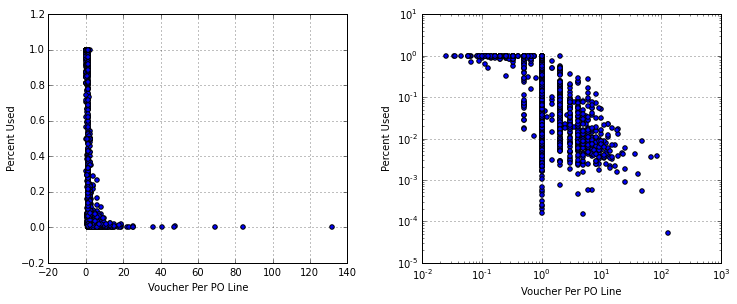

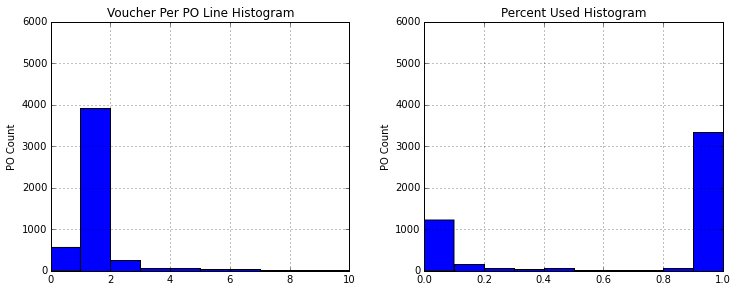

In [10]:
import matplotlib.pyplot as plt

plt.close('all')

#Layout the subplot
fig,(axis0,axis1) = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
fig.tight_layout()
fig.subplots_adjust(wspace=.25)

#Plot the raw data on a log scale to visually inspect the data.
ax0 = PO_features.plot(subplots=True, ax=axis0, legend=False, x='Voucher Per PO Line', y='Percent Used', kind='scatter');
ax1 = PO_features.plot(subplots=True, ax=axis1, legend=False, x='Voucher Per PO Line', y='Percent Used', kind='scatter',loglog=True);
plt.show()

fig2,axis = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
fig2.tight_layout()
fig2.subplots_adjust(wspace=.25)

ax2 = PO_features['Voucher Per PO Line'].plot(subplots=True, ax=axis[0], legend=False, kind='hist', bins=[0,1,2,3,4,5,6,7,8,9,10])
ax3 = PO_features['Percent Used'].plot(subplots=True, ax=axis[1], legend=False, kind='hist');
axis[0].set_title('Voucher Per PO Line Histogram')
axis[0].set_ylabel('PO Count')
axis[0].axis((0,10,0,6000))
axis[1].set_title('Percent Used Histogram')
axis[1].set_ylabel('PO Count')
axis[1].axis((0,1,0,6000))
plt.show()


##Use Rules to Find Blankets

<Font FACE= Times><Font Size= 4> A Purchase Order is an offical authorization to pay a supplier for goods or services.  Under most cases, we would expect the supplier to charge the full authorized amount listed on the PO, since they are able to do so.  Also, issuing invoices comes with the cost of postage, effort, management, etc.  As a result, we would expect Supplier to prefer billing the entire PO amount on 1 invoice (voucher).  Instances where this preference is no observed are most likely blanket POs.

In [18]:
#It is highly likely that anything getting 3x1 vouchers to po lines and used less than 90% is a 
#blanket PO.
Blanket_Filter = PO_features[(PO_features['Voucher Per PO Line'] >= 3)]

data_filtered['Is Blanket'] = data_filtered['PO #'].isin(Blanket_Filter['PO #'])



C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


##Some quick analytics and more visualization

<Font FACE= Times><Font Size= 4> With our new found ability to approximate which POs are Blankets, we can now identify those campus officials who are using blankets and assess whether their are better processes to use with their supplier partners.  Ultimately, solving either the behavior or inadequite processes.

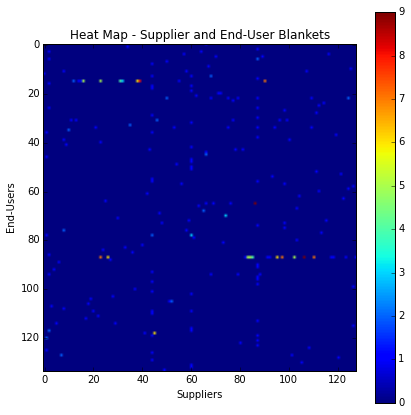

In [21]:
#Who is the most prolific issuer of Blanket POs
data_filtered.columns
#calculate for every department the total blankets and total POs
Dept_Pivot = pivot_table(data_filtered[data_filtered['Is Blanket']==True], 
                         rows=['Invoice Owner'], 
                         columns=['Supplier Name'],
                         values = ['PO #'], 
                         aggfunc = [lambda x: len(x.unique())],
                         fill_value=0)


#Dept_Pivot = Dept_Pivot.reset_index()
#Dept_Pivot[Dept_Pivot['Is Blanket'] == True].sort(('<lambda>','PO #'),ascending=0).head()
fig3,ax = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
imgplot = plt.imshow(Dept_Pivot)
#imgplot.set_cmap('spectral')
ax.set_title('Heat Map - Supplier and End-User Blankets')
ax.set_ylabel('End-Users')
ax.set_xlabel('Suppliers')
plt.colorbar();

In [22]:
Dept_Pivot

<lambda>                        \
                                        PO #                         
Supplier Name          AAA Business Supplies ALLIANCE GAS PRODUCTS   
Invoice Owner                                                        
Abby Bradbury                              0                     0   
Ali Mansour                                0                     0   
Alice WONG                                 0                     0   
Alyssa Fong                                0                     0   
Amanda Palmquist                           0                     0   
Andrew Fletcher                            0                     0   
Angelique Tolliver                         0                     0   
Anna L. Engelbrektson                      0                     0   
Arezou Razavi                              0                     0   
BLAIR GAINOUS                              0                     0   
Barbara J. McWilliams                      0                     0   
Bennie MITCHELL                            0                     0   
Boban Zarkovich                            1                     0   
Brandi Bankston                            0                     0   
Briana Morgan                              0                     0   
Brianna Shelton                            0                     0   
Brittany Bianchi                           0                     0   
Bruno Martinez                             0                     0   
Catherine DEA                              0                     0   
Charlene C. Bashore                        0                     0   
Chris Cicala                               0                     0   
Chris JANSEN                               0                     0   
Christopher T. CLARK                       0                     0   
Claudette Begin                            0                     0   
Cristina Bentley                           0                     0   
DARY S. HONG                               0                     0   
Dana Jantz                                 0                     0   
David Castellanos                          0                     0   
Deane Wallace                              0                     0   
Devon Hunerdosse                           0                     0   
...                                      ...                   ...   
Rosa GARCIA                                0                     0   
Roxanne Egan                               0                     0   
Roy A. BARIL                               0                     0   
Sahil Sheth                                0                     0   
Sal Genito                                 0                     0   
Samuel Ng                                  0                     0   
Scott Gradia                               0                     0   
Shalia McDonald                            0                     0   
Sheila Caguiat                             0                     0   
Shela Deguzman                             0                     0   
Sheryl BARRIOS                             0                     0   
Sophia Sanjeeta Chahal                     0                     0   
Stephanie Eistetter                        0                     0   
Sue BURCHFIELD                             0                     0   
Sunil Chacko                               0                     0   
Susan C MEUX                               0                     0   
Susan KELLOGG-SMITH                        0                     2   
Tamara Katoni                              0                     0   
Tayo Oguns                                 0                     0   
Terry JACKSON                              0                     0   
Todd McFerren                              0                     0   
Tsering Youdon                             0                     1   
Vedud Purde                                0  